In [2]:
#Import required packages
import numpy as np
import regex as re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statistics
import math
import os

from tqdm import tqdm

from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
import tokenizers
from transformers import pipeline, AutoTokenizer, TFRobertaModel, RobertaTokenizer, RobertaConfig, DistilBertTokenizer, TFDistilBertModel, DistilBertConfig

from collections import Counter
from timeit import default_timer as timer

import warnings
warnings.filterwarnings("ignore")

In [3]:
df = pd.read_csv('tfidf_dataset.csv') #Import the data using read_csv from pandas
df.head() # Show the first 5 records in the dataset

,index,text,category
0,0,musicians tackle red tape musicians groups tac...,entertainment
1,1,u2 desire number u2 won prestigious grammy awa...,entertainment
2,2,rocker doherty stage fight rock singer pete do...,entertainment
3,3,snicket tops box office chart film adaptation ...,entertainment
4,4,ocean raids box office ocean crime caper seque...,entertainment


In [4]:
# Use sklearn Label Encoder to create new column with category as number instead of text
le = LabelEncoder()
df['Category_label'] = le.fit_transform(df['category'])

In [5]:
# Create a dictionary that maps category to label
label_dict = (df[['category', 'Category_label']].drop_duplicates()
             .sort_values(by='Category_label')
              .reset_index(drop=True)['category']
              .to_dict())

# Print statement to check items included in dictionary
for index, key in label_dict.items():
    print(index, key)

0 business
1 entertainment
2 politics
3 sport
4 tech


In [7]:
# Create train, test and validation splits of the data
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['Category_label'], test_size = 0.2, random_state = 777)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2, random_state = 777)

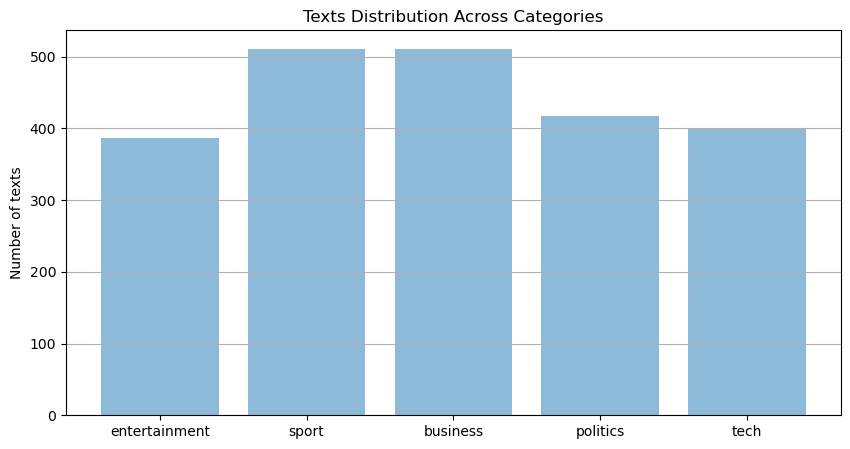

Counter({'sport': 511, 'business': 510, 'politics': 417, 'tech': 401, 'entertainment': 386})


In [8]:
# Visualise distribution of text data across the different categories and provide a count of articles in each category

categories = df[['category']].values.reshape(-1) # Extract values from category column and convert into a 1D array

counter_categories = Counter(categories) # Count frequency of each unique category. Counter holds the names and values like a dictionary using values set below
category_names = counter_categories.keys() # Extracts and stores the names of categories
category_values = counter_categories.values() # Extracts and stores the value counts

#Create chart
y_pos = np.arange(len(category_names))

plt.figure(1, figsize=(10, 5))
plt.bar(y_pos, category_values, align='center', alpha=0.5)
plt.xticks(y_pos, category_names)
plt.ylabel('Number of texts')
plt.title('Texts Distribution Across Categories')
plt.gca().yaxis.grid(True)
plt.show()

#Print value counts by category
print(counter_categories)

In [9]:
# Calculate statistics in relation to the dataset
def calculate_stats(df, split_char=' '):
    categories = df['category'].unique() # Retrieve unique category values from dataframe
    
    all_lengths = [] # Initialise empty list to store the lengths of the texts
    per_category = { #Initialise dictionary which contains sub-dictionaries to store the length, mean, and standard deviation of each category
        'lengths': {c:[] for c in categories},
        'mean': {c:0 for c in categories},
        'stdev': {c:0 for c in categories}
    }
    
    for index, row in df.iterrows(): # Loop through each line in dataframe
        text = row['text'] # Extract the text content from that line
        text = re.sub(r"\s+", ' ', text) #Normalise by replacing consecutive whitespace with a single space using regex
        text = text.split(split_char) #Splits text into a list of words
        l = len(text) #Stores the length of each text in a variable
        
        category = row['category'] #Extract the category of the current row
        
        all_lengths.append(l) #Append the length of the current document to the all_lengths list
        per_category['lengths'][category].append(l) # Append the length of the current document to the corresponding category list in the per_category dictionary
        
    for c in categories:
        per_category['mean'][c] = statistics.mean(per_category['lengths'][c]) # Calculate mean of text lengths per category
        per_category['stdev'][c] = statistics.stdev(per_category['lengths'][c]) # Calculate stdev of text lengths per category
        
    global_stats = {
        'mean': statistics.mean(all_lengths), # As above but across all texts in all categories
        'stdev': statistics.stdev(all_lengths),
        'lengths': all_lengths
    }
    
    return { # Return statement that returns a dictionary containing the per-category and the global statistics
        'global': global_stats,
        'per_category': pd.DataFrame(per_category)
    }

# Produce histogram visualisations of the lengths of texts
def display_lengths_histograms(df_stats, n_cols=3):
    categories = df['category'].unique() # As above
    n_rows = math.ceil(len(categories) / n_cols) # Calculate number of rows needed for subplot grid based on the number of unique categories and the specified number of columns above (n=3)
    
    plt.figure(figsize=(15, 8)) # Initialise main plot which houses suplots
    plt.suptitle('Distribution of lengths')
    
    # Subplot of all lengths
    plt.subplot(n_rows, n_cols, 1) # Index 1...the first plot
    plt.title('All categories')
    lengths = df_stats['global']['lengths'] # Plot the global lengths
    plt.hist(lengths, color='r') # Colour red

    # Subplot of each category
    index_subplot = 2 # Second subplot...
    for c in categories: # For each category...(0-5)
        plt.subplot(n_rows, n_cols, index_subplot)
        plt.title('Category: %s' % c)
        
        lengths = df_stats['per_category']['lengths'][c] # Plot the lengths by category
        plt.hist(lengths, color='b') # Colour blue

        index_subplot += 1 # Move to next subplot for next category in the loop

    plt.show() # Print out the visualisation of all subplots

In [10]:
# Store stats in dataframe and show results
df_stats = calculate_stats(df)
df_stats['per_category']

,lengths,mean,stdev
entertainment,"[165, 375, 174, 108, 167, 189, 130, 230, 115, ...",168.585492,118.648402
sport,"[86, 86, 92, 72, 71, 68, 703, 257, 226, 71, 71...",159.681018,92.709783
business,"[90, 82, 105, 169, 229, 321, 100, 85, 82, 127,...",172.876471,65.119283
politics,"[115, 297, 289, 116, 208, 235, 231, 183, 113, ...",215.347722,128.812873
tech,"[194, 117, 274, 135, 223, 170, 222, 165, 168, ...",241.835411,103.570666


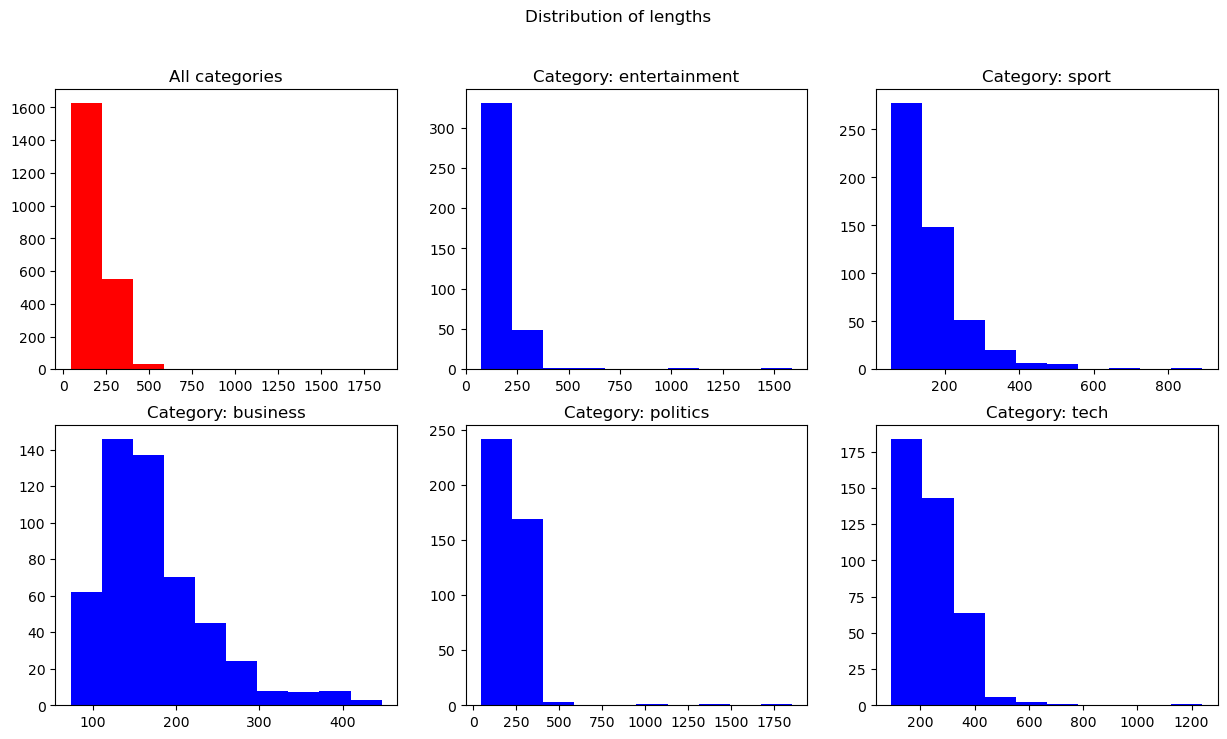

In [11]:
display_lengths_histograms(df_stats) # Run function to plot histogram based off the results in newly created df_stats

In [12]:
n_texts = len(df) # Store the number of articles in the dataframe as a variable named n_texts
print('Texts in dataset: %d' % n_texts) # Print the number of texts in the dataset

categories = df['category'].unique() #Store a list of unique categories in a variable named categories
n_categories = len(categories) # Store number of total unique categories in a variable named n_categories
print('Number of categories: %d' % n_categories) #Print the number of unique categories

Texts in dataset: 2225
Number of categories: 5


In [13]:
#Import TF-IDF vectorizer and initialise it
#Sublinear df reduces impact of very frequent terms by applying sublinear scaling, replacing TF values with 1 + log(TF)
#min_df states a word must appear in at least 10 documents to be included in the vocabulary - helps remove rare words
#ngram_range considers both unigrams and bigrams to help capture important combinations of words
#stop_words removes common English stop words such as 'is' and 'the' as they carry very little semantic meaning
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=10, norm='l2',encoding='latin-1', ngram_range=(1,2), stop_words='english')

features = tfidf.fit_transform(df.text).toarray() # Applies the vectorizer to the text column of the data and transforms it to a TF-IDF matrix and then converts it into a numPy array
labels = df.Category_label # Extracts the category label from the dataframe and assigns it to the variable 'labels'
features.shape # Shows the shape of the array, which shows the 2,225 rows (number of articles) and 6281 columns (number of unique terms in the matrix)

(2225, 6281)

In [13]:
#Chi-Sqaured

from sklearn.feature_selection import chi2 # Import chi2 function from sklearn

N=3 # Assign a number to show the top N unigrams and bigrams of each category
for Category_label, category,  in sorted(label_dict.items()): # Loop over each item in the label_dict dictionary
    features_chi2 = chi2(features,labels == Category_label) # Calculate chi2 statistic between features and labels
    indices = np.argsort(features_chi2[0]) # Sort the features by correlation score
    feature_names = np.array(tfidf.get_feature_names_out())[indices] # Extract the feature names and sort them in the same order as the indices
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1] # Create list of unigrams
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2] # Create list of bigrams
    #Print statement to show category header and then the top 3 correlated unigrams and bigrams
    print("# '{}':".format(category))
    print("  Most correlated unigrams:\n     .{}".format('\n     .'.join(unigrams[-N:])))
    print("  Most correlated bigrams:\n     .{}".format('\n     .'.join(bigrams[-N:])))

# 'business':
  Most correlated unigrams:
     .bank
     .growth
     .shares
  Most correlated bigrams:
     .stock market
     .economic growth
     .oil prices
# 'entertainment':
  Most correlated unigrams:
     .singer
     .actor
     .film
  Most correlated bigrams:
     .los angeles
     .film festival
     .box office
# 'politics':
  Most correlated unigrams:
     .party
     .blair
     .labour
  Most correlated bigrams:
     .mr brown
     .tony blair
     .mr blair
# 'sport':
  Most correlated unigrams:
     .coach
     .match
     .cup
  Most correlated bigrams:
     .australian open
     .champions league
     .grand slam
# 'tech':
  Most correlated unigrams:
     .computer
     .software
     .users
  Most correlated bigrams:
     .mobile phones
     .mobile phone
     .anti virus


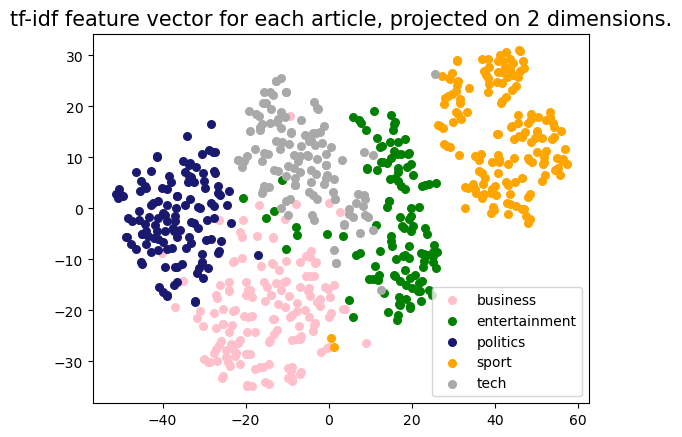

In [14]:
#TSNE - create 2D projection of the high-dimensional feature space
from sklearn.manifold import TSNE # Import t-SNE algorithm from sklearn

SAMPLE_SIZE = int(len(features)*0.3) # Create a smaller sample size to help visualise the data, 30% of full dataset
np.random.seed(0) # Set random seed for reproducibility
indices = np.random.choice(range(len(features)), size=SAMPLE_SIZE, replace=False) #Randomly select indices from the range of features to create the random subset
projected_features = TSNE(n_components=2, random_state=0).fit_transform(features[indices]) #Project the features into a 2D space
colors = ['pink', 'green', 'midnightblue', 'orange', 'darkgrey'] # Choose chart colours
for Category_label, category,  in sorted(label_dict.items()): #Loop over each item in label_dict dictionary
    points = projected_features[(labels[indices] == Category_label).values] # Extract features (2D points) that relate to the current category of the loop
    plt.scatter(points[:,0], points[:,1], s=30, c=colors[Category_label], label=category) # Create a scatter plot for the above points
plt.title("tf-idf feature vector for each article, projected on 2 dimensions.",
         fontdict=dict(fontsize=15))
plt.legend()

In [15]:
#Import the different baseline models from sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB

#Import cross_val_score function from sk_learn which performs k-fold CV to assess model performance
from sklearn.model_selection import cross_val_score

#Initialise a list containing each ofthe models
models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]
CV = 5 # Set the number of cross validation folds
cv_df = pd.DataFrame(index=range(CV * len(models))) # Iitialise an empty dataframe called cv_df to store the results
entries = [] # Initialise empty list to store the results and populate the dataframe
for model in models: # Loop through each model
    model_name = model.__class__.__name__ # Retrieve name of class for current model and assigns to model_name
    accuracies = cross_val_score(model,features,labels,scoring='accuracy', cv=CV) # Perform k-fold cross val for current model, scoring it using 'accuracy' as the evaluation metric and store accuracy in a variable
    for fold_idx, accuracy in enumerate(accuracies): # Iterate through list of accuracy scores from CV of current model
        entries.append((model_name, fold_idx, accuracy)) # Append tuple containing model name, k-fold number and accurac score for each fold of each model
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy']) # Add all data to dataframe

In [16]:
cv_df # Review the results of k-fold cross validation on each model

,model_name,fold_idx,accuracy
0,RandomForestClassifier,0,0.851685
1,RandomForestClassifier,1,0.831461
2,RandomForestClassifier,2,0.802247
3,RandomForestClassifier,3,0.833708
4,RandomForestClassifier,4,0.826966
5,MultinomialNB,0,0.979775
6,MultinomialNB,1,0.973034
7,MultinomialNB,2,0.970787
8,MultinomialNB,3,0.973034
9,MultinomialNB,4,0.966292


<Axes: xlabel='model_name', ylabel='accuracy'>

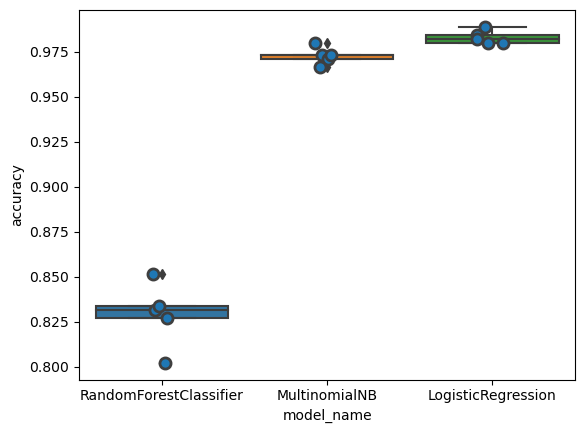

In [17]:
#View the results in a box plot visual
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name',y='accuracy', data=cv_df,
              size=8, jitter=True, edgecolor='gray', linewidth=2)

In [18]:
# Identify the model with the highest mean accuracy
cv_df.groupby('model_name').accuracy.mean()

model_name
LogisticRegression        0.982921
MultinomialNB             0.972584
RandomForestClassifier    0.829213
Name: accuracy, dtype: float64

## Logistic Regression Baseline Model 

In [19]:
#Split the baseline dataset into train and test sets, using 80% of data to train the model
bx_train, bx_test, by_train, by_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size = 0.2, random_state = 777)
model = LogisticRegression(random_state=0)
#Train the logistic regression model
model.fit(bx_train,by_train)
# Make predictions on the test set using the model
y_hat = model.predict(bx_test)

Accuracy: 0.9707865168539326


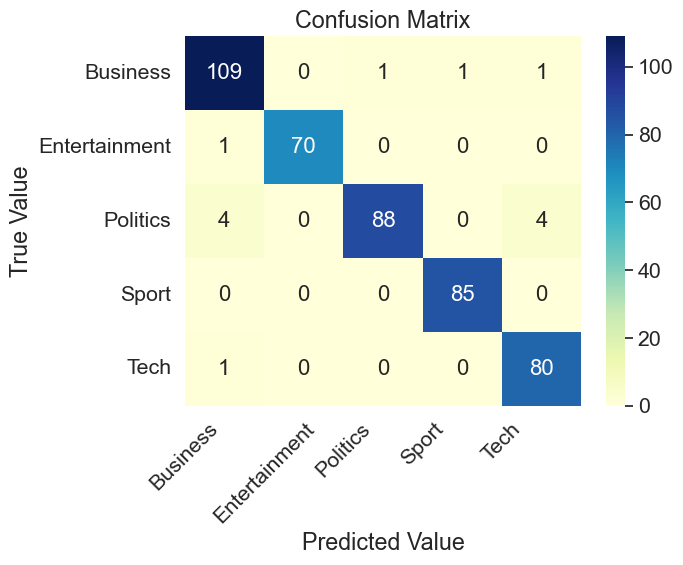

In [20]:
print("Accuracy:", accuracy_score(by_test, y_hat)) #Print model accuracy score
labels_5 = ['Business','Entertainment','Politics','Sport','Tech'] # Assign labels to variables for confusion matrix
conf_mat = confusion_matrix(by_test, y_hat) # Create confusion matrix on the model prediction results
def print_cf1(by_test, y_hat): # Function to print the confusion matrix
    cm = confusion_matrix(by_test, y_hat)
    sns.set(font_scale = 1.4, color_codes=True, palette="deep")
    sns.heatmap(pd.DataFrame(cm, index=labels_5,columns=[0,1,2,3,4]), 
                annot = True,
                annot_kws = {"size":16},
                fmt="d",
                cmap="YlGnBu")
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Value")
    plt.xticks([0,1,2,3,4], labels_5, rotation=45)
    plt.ylabel("True Value")
    plt.show()
    
print_cf1(by_test, y_hat)

In [21]:
print(classification_report(by_test,y_hat,target_names=labels_5)) # Print classification report showing scores per class and overall

               precision    recall  f1-score   support

     Business       0.95      0.97      0.96       112
Entertainment       1.00      0.99      0.99        71
     Politics       0.99      0.92      0.95        96
        Sport       0.99      1.00      0.99        85
         Tech       0.94      0.99      0.96        81

     accuracy                           0.97       445
    macro avg       0.97      0.97      0.97       445
 weighted avg       0.97      0.97      0.97       445



## DistilBERT

In [23]:
MODEL_NAME = 'distilbert-base-cased' # Assign distilbert to the model name

In [24]:
tokenizer = DistilBertTokenizer.from_pretrained(MODEL_NAME) # Utilise the distilbert tokenizer

In [25]:
max_val = 0 = #Initialise a variable called max_val to store the maximum text length
for sent in (X_train.to_list() + X_train.tolist() + X_val.tolist()): #Loop thorugh list of all sentences
    try:
        sent_tok_len = len(tokenizer.tokenize(sent)) # store the length of the current sentence
        max_val = sent_tok_len if (sent_tok_len > max_val) else max_val #If current length is highest so far, assign it to max_val
    except:
        pass
    
print(f"The maximum number of tokens in the dataset is {max_val}") # Print the maximum article length

The maximum number of tokens in the dataset is 2504


In [26]:
MAX_LENGTH = 512 # Define a max length value for texts that will be processed by the code. 512 is the DistilBERT and RoBERTa limit

tokenizer = DistilBertTokenizer.from_pretrained(MODEL_NAME,  # Initialise pre-trained DistilBERT tokenizer
                                                add_special_tokens=True, # Add special tokens
                                                max_length=MAX_LENGTH, # Set max length
                                                pad_to_max_length=True) # Pad articles to the maximum length if too short

def tokenize(sentences, tokenizer): # Define function to tokenize the sentences using the above tokenizer
    input_ids, input_masks, input_segments = [], [], [] # Initialise 3 empty lists to store tokenized representations of the input articles
    for sentence in tqdm(sentences): #Loop over the sentences in the sentences list. Show progress using tqdm
        inputs = tokenizer.encode_plus(sentence, # Tokenize each sentence
                                       add_special_tokens=True, 
                                       max_length=MAX_LENGTH, 
                                       pad_to_max_length=True, 
                                       return_attention_mask=True, 
                                       return_token_type_ids=True, 
                                       truncation=True)
        input_ids.append(inputs['input_ids']) # Append tokenized input IDs
        input_masks.append(inputs['attention_mask']) #Append attention mask which indicates which tokens are part of the input
        input_segments.append(inputs['token_type_ids'])  # Appends token type IDs which is used in models accepting pairs of sequences       
        
    return np.asarray(input_ids, dtype='int32'), np.asarray(input_masks, dtype='int32') # Return 3 numPy arrays as a tuple. They contain the tokenized representations of the input sentences

In [27]:
start = timer() # Start timer for DistilBERT
x_train = tokenize(X_train, tokenizer) #Run tokenization function on train data
x_test = tokenize(X_test, tokenizer) # Run tokenization function on test data
x_val = tokenize(X_val, tokenizer) # Run tokenization function on validation data

100%|███████████████████████████████████████████████████████████████████████████████| 356/356 [00:01<00:00, 306.66it/s]


In [28]:
# Load the config for DistilBERT from the pre-trained DistilBERT model
config = DistilBertConfig.from_pretrained(MODEL_NAME, output_hidden_states=True, output_attentions=True) 
DistilBERT = TFDistilBertModel.from_pretrained(MODEL_NAME, config=config) # Initialise the tensor flow compatible model using the above config

input_ids_in = tf.keras.layers.Input(shape=(MAX_LENGTH,), name='input_token', dtype='int32') # Define input layer for model with a max length of 512
input_masks_in = tf.keras.layers.Input(shape=(MAX_LENGTH,), name='masked_token', dtype='int32') # Another input layer, representing attention mask for the input tokens

embedding_layer = DistilBERT(input_ids = input_ids_in, attention_mask = input_masks_in)[0] # Apply DistilBERT model to the input data. Returns tuple from input ids and input masks and extracts the first element
X = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True))(embedding_layer) # Define bidirectional LSTM layer with 128 units. Captures contextual information from the input embeddings
X = tf.keras.layers.GlobalMaxPool1D()(X) # Apply global max pooling to the sequences. Extracts maximum value from each feature dimension across entire sequence, reducing sequence length
X = tf.keras.layers.Dense(64, activation='relu')(X) # Apply dense layer with 64 units and a ReLU activation function
X = tf.keras.layers.Dropout(0.2)(X) # Apply dropout regularisation with a rate of 0.2 to help prevent overfitting
X = tf.keras.layers.Dense(5, activation='softmax')(X) # Apply another 5 unit dense layer and softmax activation function. Used in multiclass classification to produce probability distributions over the classes

model = tf.keras.Model(inputs=[input_ids_in, input_masks_in], outputs = X) # Define the final model by specifying final inputs and outputs

for layer in model.layers[:3]:
    layer.trainable = False # Freexe the first 3 layers of the model to keep the pre-trained weights for initial layers - common practice

model.summary() #Print a summary of the model architecture

Some layers from the model checkpoint at distilbert-base-cased were not used when initializing TFDistilBertModel: ['activation_13', 'vocab_transform', 'vocab_projector', 'vocab_layer_norm']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_token (InputLayer)    [(None, 512)]                0         []                            
                                                                                                  
 masked_token (InputLayer)   [(None, 512)]                0         []                            
                                                                                                  
 tf_distil_bert_model (TFDi  TFBaseModelOutput(last_hid   6519091   ['input_token[0][0]',         
 stilBertModel)              den_state=(None, 512, 768)   2          'masked_token[0][0]']        
                             , hidden_states=((None, 51                                           
                             2, 768),                                                         

In [29]:
# Create a directory in which to save the model weights
output_dir = './model1_outputs'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

In [30]:
model_checkpoint = ModelCheckpoint(filepath=output_dir+'/weights.{epoch:02d}.hdf5',
                                  save_weights_only=True)

early_stopping = EarlyStopping(patience=3, # Stop after 3 epochs of no improvement
                               monitor='val_loss', # Look at validation_loss
                               min_delta=0, # After 0 change
                               mode='min', # Stop when quantity has stopped decreasing
                               restore_best_weights=False, # Don't Restore the best weights
                               verbose=1) 

reduce_lr = ReduceLROnPlateau(monitor='val_loss', # Look at validation loss
                              min_lr=0.000001, # Lower bound of learning rate
                              patience=1, # Reduce after 1 with little change
                              mode='min', # Stop when quantity has stopped decreasing
                              factor=0.1, # Reduce by a factor of 1/10
                              min_delta=0.01, # Minimumn change needed
                              verbose=1)

In [31]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy']) # Compile previously defined model
# Use sparse categorical cross entropy as loss function which is commonly used in multiclass classification problems
# Set Adam as the optimization algorithm. Commonly used as adapts the learning rate during training
# Monitor performance using accuracy

history = model.fit(x_train, # Initiate model training on train set
                   y_train,
                   epochs=10, # Set training epochs (runs over entire dataset)
                   batch_size = 16, # Set batch size which determines number of samples used in each mini batch
                   validation_data=(x_val, y_val), # Specify validation data which is used to evaluate performance after each epoch
                   callbacks = [model_checkpoint, early_stopping, reduce_lr]) # Saves weighs if validation loss improves, stops training if val loss does not improve to help overfitting, reduce learning rate if validation loss plateaus

Epoch 1/10
89/89 [==============================] - 868s 10s/step - loss: 0.7055 - accuracy: 0.7605 - val_loss: 0.2793 - val_accuracy: 0.8961 - lr: 0.0010
Epoch 2/10
89/89 [==============================] - 885s 10s/step - loss: 0.2284 - accuracy: 0.9228 - val_loss: 0.1742 - val_accuracy: 0.9410 - lr: 0.0010
Epoch 3/10
89/89 [==============================] - ETA: 0s - loss: 0.1693 - accuracy: 0.9445
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
89/89 [==============================] - 886s 10s/step - loss: 0.1693 - accuracy: 0.9445 - val_loss: 0.1682 - val_accuracy: 0.9326 - lr: 0.0010
Epoch 4/10
89/89 [==============================] - 891s 10s/step - loss: 0.1003 - accuracy: 0.9691 - val_loss: 0.1255 - val_accuracy: 0.9635 - lr: 1.0000e-04
Epoch 5/10
89/89 [==============================] - 897s 10s/step - loss: 0.0697 - accuracy: 0.9846 - val_loss: 0.1113 - val_accuracy: 0.9663 - lr: 1.0000e-04
Epoch 6/10
89/89 [==============================] - ETA: 

Lowest Validation Loss: epoch 6
Highest Validation Accuracy: epoch 6


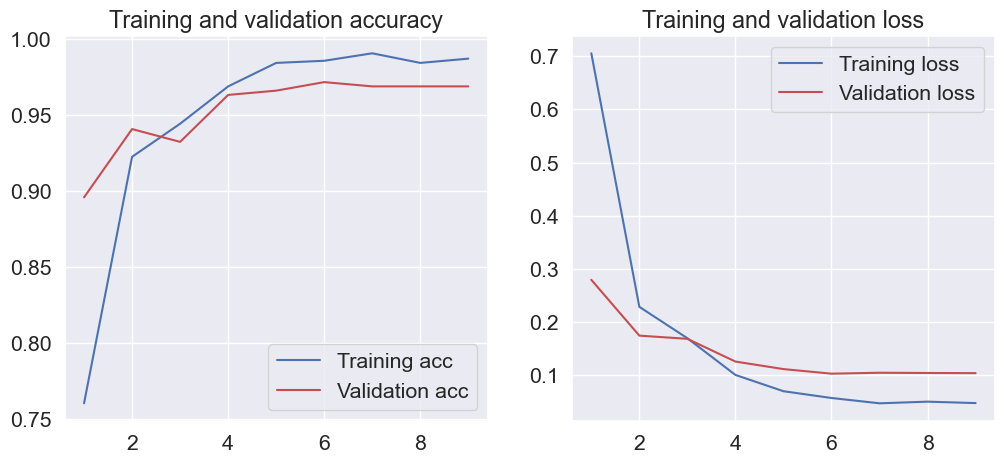

In [32]:
# Plot the training accuracy and validation accuracy per epoch and training loss and validation loss per epoch on two subplots within one figure
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    print("Lowest Validation Loss: epoch {}".format(np.argmin(val_loss)+1))
    print("Highest Validation Accuracy: epoch {}".format(np.argmax(val_acc)+1))

plot_history(history)

In [33]:
# 2 functions which return the lowest validation loss epoch, and the highest validation accuracy accuracy epoch
def get_min_val_loss_epoch(history):
    return "0"+str(np.argmin(history.history['val_loss'])+1)

def get_max_val_acc_epoch(history):
    return "0"+str(np.argmax(history.history['val_accuracy'])+1)

In [34]:
epoch_num = get_max_val_acc_epoch(history) # Assign the epoch number with the highest validation accuracy to the variable epoch_num
model.load_weights(output_dir+"/weights."+epoch_num+".hdf5") #Load these weights into the model

In [35]:
y_test_probs = model.predict(x_test) # Use the model to make predictions on the test set. 
# Model computes predicted probabilities for each class for each sentence and stores them in y_test_probs which contains
# a row per sentence and a column for each class with the calculated probability

y_hat = [] # Create an empty list which will store the predicted class labels
for prob in y_test_probs: # Loop through each row in y_test_probs
    y_hat.append(np.argmax(prob)) # Find the class with the highest predicted probability and append it to the y-hat list

14/14 [==============================] - 168s 12s/step


8229.392507999999
Accuracy: 0.9685393258426966


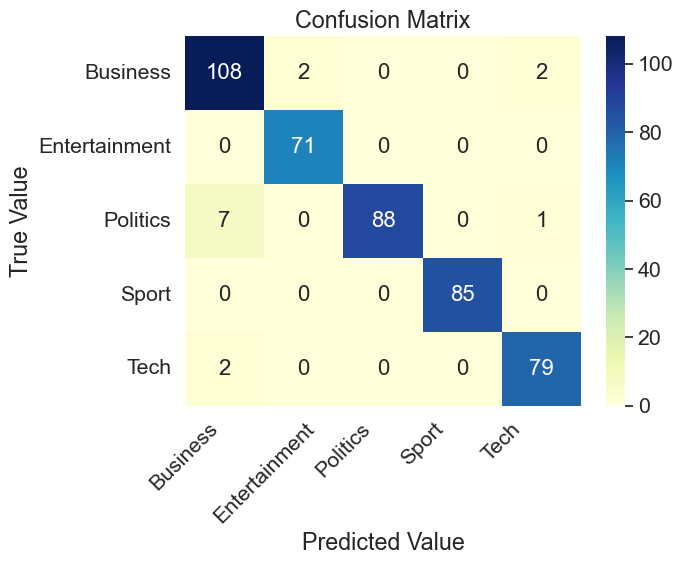

In [36]:
end = timer() # End timer for DistilBERT
print(end - start) # Print the total time taken for training and inference
print("Accuracy:", accuracy_score(y_test, y_hat)) # Print the accuracy score by comparing number of labels in y_hat that match the labels in y_test
print_cf1(y_test, y_hat) # Print confusion matrix of the results

In [37]:
print(classification_report(y_test,y_hat,target_names=labels_5)) # Print classification report to show evaluation metrics

               precision    recall  f1-score   support

     Business       0.92      0.96      0.94       112
Entertainment       0.97      1.00      0.99        71
     Politics       1.00      0.92      0.96        96
        Sport       1.00      1.00      1.00        85
         Tech       0.96      0.98      0.97        81

     accuracy                           0.97       445
    macro avg       0.97      0.97      0.97       445
 weighted avg       0.97      0.97      0.97       445



## RoBERTa

In [38]:
MODEL_NAME = 'roberta-base' # Change model name to RoBERTa
tokenizer = RobertaTokenizer.from_pretrained(MODEL_NAME) # Amend the tokenizer

# *** The code from here on in is not commented as it is a replication of the DistilBERT code with amended tokenizers and a reset timer ***

In [39]:
MAX_LENGTH = 512

tokenizer = RobertaTokenizer.from_pretrained(MODEL_NAME,  
                                                add_special_tokens=True,
                                                max_length=MAX_LENGTH, 
                                                pad_to_max_length=True)

def tokenize(sentences, tokenizer):
    input_ids, input_masks, input_segments = [], [], []
    for sentence in tqdm(sentences):
        inputs = tokenizer.encode_plus(sentence, 
                                       add_special_tokens=True, 
                                       max_length=MAX_LENGTH, 
                                       pad_to_max_length=True, 
                                       return_attention_mask=True, 
                                       return_token_type_ids=True, 
                                       truncation=True)
        input_ids.append(inputs['input_ids'])
        input_masks.append(inputs['attention_mask'])
        input_segments.append(inputs['token_type_ids'])        
        
    return np.asarray(input_ids, dtype='int32'), np.asarray(input_masks, dtype='int32')

In [40]:
start = timer()
x_train = tokenize(X_train, tokenizer)
x_test = tokenize(X_test, tokenizer)
x_val = tokenize(X_val, tokenizer)

100%|███████████████████████████████████████████████████████████████████████████████| 356/356 [00:00<00:00, 614.34it/s]


In [41]:
config = RobertaConfig.from_pretrained(MODEL_NAME, output_hidden_states=True, output_attentions=True)
Roberta = TFRobertaModel.from_pretrained(MODEL_NAME, config=config)

input_ids_in = tf.keras.layers.Input(shape=(MAX_LENGTH,), name='input_token', dtype='int32')
input_masks_in = tf.keras.layers.Input(shape=(MAX_LENGTH,), name='masked_token', dtype='int32') 

embedding_layer = Roberta(input_ids = input_ids_in, attention_mask = input_masks_in)[0]
X = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True))(embedding_layer)
X = tf.keras.layers.GlobalMaxPool1D()(X)
X = tf.keras.layers.Dense(64, activation='relu')(X)
X = tf.keras.layers.Dropout(0.2)(X)
X = tf.keras.layers.Dense(5, activation='softmax')(X)

model = tf.keras.Model(inputs=[input_ids_in, input_masks_in], outputs = X)

for layer in model.layers[:3]:
    layer.trainable = False

model.summary()

Some layers from the model checkpoint at roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_token (InputLayer)    [(None, 512)]                0         []                            
                                                                                                  
 masked_token (InputLayer)   [(None, 512)]                0         []                            
                                                                                                  
 tf_roberta_model (TFRobert  TFBaseModelOutputWithPooli   1246456   ['input_token[0][0]',         
 aModel)                     ngAndCrossAttentions(last_   32         'masked_token[0][0]']        
                             hidden_state=(None, 512, 7                                           
                             68),                                                           

In [42]:
output_dir = './model2_outputs'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
    
model_checkpoint = ModelCheckpoint(filepath=output_dir+'/weights.{epoch:02d}.hdf5',save_weights_only=True)

In [43]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(x_train,
                   y_train,
                   epochs=10,
                   batch_size = 16,
                   validation_data=(x_val, y_val),
                   callbacks = [model_checkpoint, early_stopping, reduce_lr])

Epoch 1/10
89/89 [==============================] - 1737s 19s/step - loss: 0.7024 - accuracy: 0.7746 - val_loss: 0.2085 - val_accuracy: 0.9382 - lr: 0.0010
Epoch 2/10
89/89 [==============================] - ETA: 0s - loss: 0.1751 - accuracy: 0.9501 
Epoch 2: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
89/89 [==============================] - 1773s 20s/step - loss: 0.1751 - accuracy: 0.9501 - val_loss: 0.2062 - val_accuracy: 0.9382 - lr: 0.0010
Epoch 3/10
89/89 [==============================] - 1780s 20s/step - loss: 0.0951 - accuracy: 0.9719 - val_loss: 0.1226 - val_accuracy: 0.9579 - lr: 1.0000e-04
Epoch 4/10
89/89 [==============================] - ETA: 0s - loss: 0.0687 - accuracy: 0.9810 
Epoch 4: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
89/89 [==============================] - 1776s 20s/step - loss: 0.0687 - accuracy: 0.9810 - val_loss: 0.1297 - val_accuracy: 0.9635 - lr: 1.0000e-04
Epoch 5/10
89/89 [============================

Lowest Validation Loss: epoch 3
Highest Validation Accuracy: epoch 4


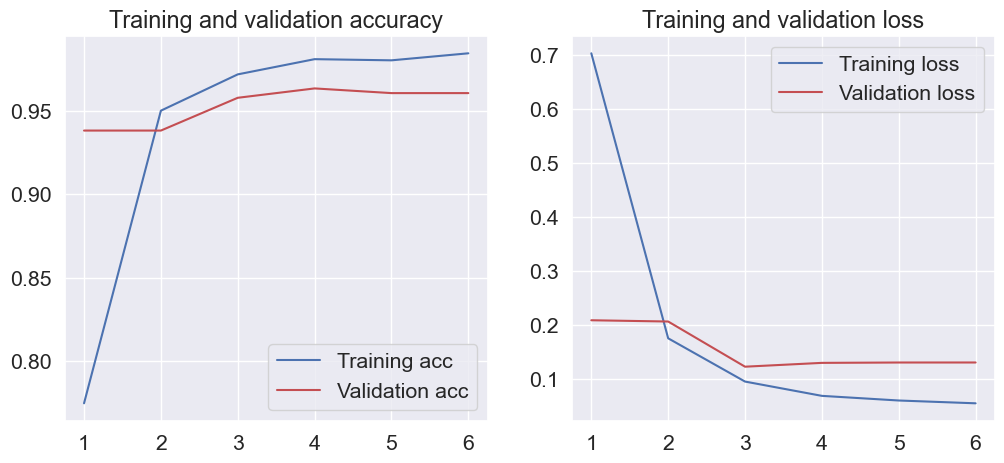

In [44]:
plot_history(history)

In [45]:
epoch_num = get_max_val_acc_epoch(history)
model.load_weights(output_dir+"/weights."+epoch_num+".hdf5")

In [46]:
y_test_probs = model.predict(x_test)

y_hat = []
for prob in y_test_probs:
    y_hat.append(np.argmax(prob))

14/14 [==============================] - 330s 23s/step


10959.7965332
Accuracy: 0.9640449438202248


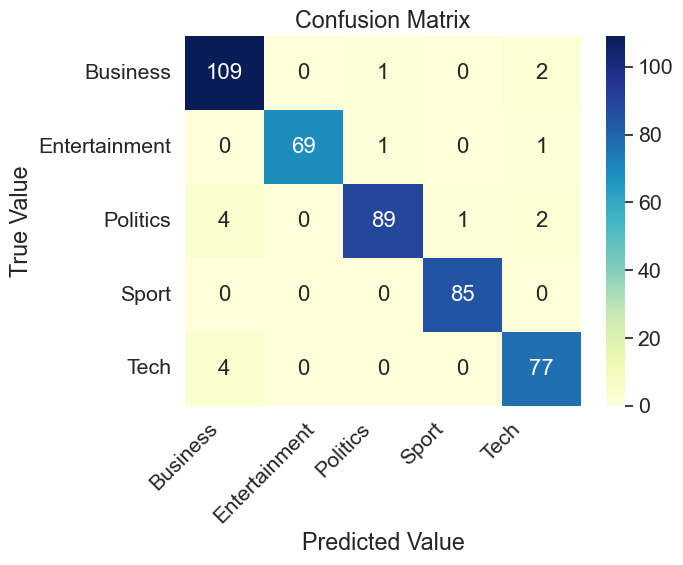

In [47]:
end = timer()
print(end - start)
print("Accuracy:", accuracy_score(y_test, y_hat))
print_cf1(y_test, y_hat)

In [48]:
print(classification_report(y_test,y_hat,target_names=labels_5))

               precision    recall  f1-score   support

     Business       0.93      0.97      0.95       112
Entertainment       1.00      0.97      0.99        71
     Politics       0.98      0.93      0.95        96
        Sport       0.99      1.00      0.99        85
         Tech       0.94      0.95      0.94        81

     accuracy                           0.96       445
    macro avg       0.97      0.96      0.97       445
 weighted avg       0.96      0.96      0.96       445

